In [49]:
import pandas as pd

# Load the dataset
df = pd.read_csv('hcV3-stories.csv')

# Select relevant columns and drop rows with missing values
df = df[['story', 'memType']].dropna()

# Filter for only 'recalled' and 'imagined' types
df = df[df['memType'].isin(['recalled', 'imagined'])]

print(df.head())


                                               story   memType
0  Concerts are my most favorite thing, and my bo...  imagined
1  The day started perfectly, with a great drive ...  recalled
2  It seems just like yesterday but today makes f...  imagined
3  Five months ago, my niece and nephew were born...  recalled
4  About a month ago I went to burning man. I was...  imagined


In [50]:
from transformers import BertTokenizer, BertModel
import torch

# Check if CUDA (GPU support) is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load pre-trained model tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(device)

def get_bert_embeddings(text):
    # Check if the text is empty or not
    if not text.strip():
        # Return a zero array of the shape (768,)
        return np.zeros((768,))
    
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Reshape the output to (768,) and return
    return outputs.last_hidden_state.mean(1).cpu().numpy().reshape(-1)

# Apply the function to the dataset
df['bert_embeddings'] = df['story'].apply(get_bert_embeddings)


Using device: cuda


In [51]:
import numpy as np 

from sklearn.model_selection import train_test_split

# Splitting the data - 60% training, 20% validation, 20% test
train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['memType'])
train_df, val_df = train_test_split(train_val_df, test_size=0.25, random_state=42, stratify=train_val_df['memType'])

# Extracting features and labels
X_train = np.array(train_df['bert_embeddings'].tolist())
y_train = train_df['memType'].values

X_val = np.array(val_df['bert_embeddings'].tolist())
y_val = val_df['memType'].values

X_test = np.array(test_df['bert_embeddings'].tolist())
y_test = test_df['memType'].values



In [67]:
#Model Training and Validation
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss
import numpy as np

# Initialize the model with logistic loss
model = SGDClassifier(loss='log_loss', learning_rate='constant', eta0=0.001, penalty='l2', max_iter=1, warm_start=True, random_state=42)

# Arrays to store losses
train_losses = []
val_losses = []

# Number of epochs
n_epochs = 100

# Training loop
for epoch in range(n_epochs):
    model.fit(X_train, y_train)
    
    # Predict probabilities on training and validation sets
    train_probs = model.predict_proba(X_train)
    val_probs = model.predict_proba(X_val)
    
    # Compute log loss
    train_loss = log_loss(y_train, train_probs)
    val_loss = log_loss(y_val, val_probs)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{n_epochs}, Train loss: {train_loss:.4f}, Validation loss: {val_loss:.4f}")


/common/home/rsv39/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/common/home/rsv39/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/common/home/rsv39/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/common/home/rsv39/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/common/home

Epoch 1/100, Train loss: 0.6738, Validation loss: 0.6710
Epoch 2/100, Train loss: 0.6580, Validation loss: 0.6535
Epoch 3/100, Train loss: 0.6468, Validation loss: 0.6412
Epoch 4/100, Train loss: 0.6381, Validation loss: 0.6318
Epoch 5/100, Train loss: 0.6309, Validation loss: 0.6243
Epoch 6/100, Train loss: 0.6248, Validation loss: 0.6181
Epoch 7/100, Train loss: 0.6195, Validation loss: 0.6129


/common/home/rsv39/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/common/home/rsv39/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/common/home/rsv39/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/common/home/rsv39/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/common/home

Epoch 8/100, Train loss: 0.6147, Validation loss: 0.6083
Epoch 9/100, Train loss: 0.6105, Validation loss: 0.6044
Epoch 10/100, Train loss: 0.6067, Validation loss: 0.6009
Epoch 11/100, Train loss: 0.6032, Validation loss: 0.5979
Epoch 12/100, Train loss: 0.5999, Validation loss: 0.5951
Epoch 13/100, Train loss: 0.5969, Validation loss: 0.5926
Epoch 14/100, Train loss: 0.5941, Validation loss: 0.5904
Epoch 15/100, Train loss: 0.5915, Validation loss: 0.5884


/common/home/rsv39/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/common/home/rsv39/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/common/home/rsv39/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/common/home/rsv39/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/common/home

Epoch 16/100, Train loss: 0.5891, Validation loss: 0.5865
Epoch 17/100, Train loss: 0.5868, Validation loss: 0.5848
Epoch 18/100, Train loss: 0.5846, Validation loss: 0.5833
Epoch 19/100, Train loss: 0.5826, Validation loss: 0.5818
Epoch 20/100, Train loss: 0.5806, Validation loss: 0.5805
Epoch 21/100, Train loss: 0.5787, Validation loss: 0.5792
Epoch 22/100, Train loss: 0.5770, Validation loss: 0.5781
Epoch 23/100, Train loss: 0.5753, Validation loss: 0.5770


/common/home/rsv39/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/common/home/rsv39/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/common/home/rsv39/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/common/home/rsv39/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/common/home

Epoch 24/100, Train loss: 0.5736, Validation loss: 0.5760
Epoch 25/100, Train loss: 0.5721, Validation loss: 0.5751
Epoch 26/100, Train loss: 0.5706, Validation loss: 0.5742
Epoch 27/100, Train loss: 0.5691, Validation loss: 0.5734
Epoch 28/100, Train loss: 0.5677, Validation loss: 0.5726
Epoch 29/100, Train loss: 0.5664, Validation loss: 0.5719
Epoch 30/100, Train loss: 0.5651, Validation loss: 0.5712
Epoch 31/100, Train loss: 0.5638, Validation loss: 0.5706


/common/home/rsv39/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/common/home/rsv39/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/common/home/rsv39/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/common/home/rsv39/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/common/home

Epoch 32/100, Train loss: 0.5626, Validation loss: 0.5700
Epoch 33/100, Train loss: 0.5614, Validation loss: 0.5694
Epoch 34/100, Train loss: 0.5603, Validation loss: 0.5689
Epoch 35/100, Train loss: 0.5592, Validation loss: 0.5684
Epoch 36/100, Train loss: 0.5581, Validation loss: 0.5679
Epoch 37/100, Train loss: 0.5571, Validation loss: 0.5675
Epoch 38/100, Train loss: 0.5560, Validation loss: 0.5671
Epoch 39/100, Train loss: 0.5550, Validation loss: 0.5667


/common/home/rsv39/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/common/home/rsv39/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/common/home/rsv39/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/common/home/rsv39/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/common/home

Epoch 40/100, Train loss: 0.5541, Validation loss: 0.5663
Epoch 41/100, Train loss: 0.5531, Validation loss: 0.5659
Epoch 42/100, Train loss: 0.5522, Validation loss: 0.5656
Epoch 43/100, Train loss: 0.5513, Validation loss: 0.5652
Epoch 44/100, Train loss: 0.5505, Validation loss: 0.5649
Epoch 45/100, Train loss: 0.5496, Validation loss: 0.5646
Epoch 46/100, Train loss: 0.5488, Validation loss: 0.5644
Epoch 47/100, Train loss: 0.5480, Validation loss: 0.5641


/common/home/rsv39/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/common/home/rsv39/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/common/home/rsv39/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/common/home/rsv39/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/common/home

Epoch 48/100, Train loss: 0.5472, Validation loss: 0.5639
Epoch 49/100, Train loss: 0.5464, Validation loss: 0.5636
Epoch 50/100, Train loss: 0.5456, Validation loss: 0.5634
Epoch 51/100, Train loss: 0.5449, Validation loss: 0.5632
Epoch 52/100, Train loss: 0.5441, Validation loss: 0.5630
Epoch 53/100, Train loss: 0.5434, Validation loss: 0.5628


/common/home/rsv39/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/common/home/rsv39/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/common/home/rsv39/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/common/home/rsv39/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/common/home

Epoch 54/100, Train loss: 0.5427, Validation loss: 0.5626
Epoch 55/100, Train loss: 0.5420, Validation loss: 0.5624
Epoch 56/100, Train loss: 0.5413, Validation loss: 0.5623
Epoch 57/100, Train loss: 0.5407, Validation loss: 0.5621
Epoch 58/100, Train loss: 0.5400, Validation loss: 0.5619
Epoch 59/100, Train loss: 0.5394, Validation loss: 0.5618
Epoch 60/100, Train loss: 0.5388, Validation loss: 0.5617


/common/home/rsv39/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/common/home/rsv39/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/common/home/rsv39/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/common/home/rsv39/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/common/home

Epoch 61/100, Train loss: 0.5381, Validation loss: 0.5615
Epoch 62/100, Train loss: 0.5375, Validation loss: 0.5614
Epoch 63/100, Train loss: 0.5369, Validation loss: 0.5613
Epoch 64/100, Train loss: 0.5363, Validation loss: 0.5612
Epoch 65/100, Train loss: 0.5358, Validation loss: 0.5611
Epoch 66/100, Train loss: 0.5352, Validation loss: 0.5610
Epoch 67/100, Train loss: 0.5346, Validation loss: 0.5609
Epoch 68/100, Train loss: 0.5341, Validation loss: 0.5608


/common/home/rsv39/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/common/home/rsv39/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/common/home/rsv39/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/common/home/rsv39/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/common/home

Epoch 69/100, Train loss: 0.5335, Validation loss: 0.5607
Epoch 70/100, Train loss: 0.5330, Validation loss: 0.5607
Epoch 71/100, Train loss: 0.5325, Validation loss: 0.5606
Epoch 72/100, Train loss: 0.5320, Validation loss: 0.5605
Epoch 73/100, Train loss: 0.5314, Validation loss: 0.5604
Epoch 74/100, Train loss: 0.5309, Validation loss: 0.5604
Epoch 75/100, Train loss: 0.5304, Validation loss: 0.5603


/common/home/rsv39/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/common/home/rsv39/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/common/home/rsv39/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/common/home/rsv39/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/common/home

Epoch 76/100, Train loss: 0.5299, Validation loss: 0.5603
Epoch 77/100, Train loss: 0.5295, Validation loss: 0.5602
Epoch 78/100, Train loss: 0.5290, Validation loss: 0.5602
Epoch 79/100, Train loss: 0.5285, Validation loss: 0.5601
Epoch 80/100, Train loss: 0.5280, Validation loss: 0.5601
Epoch 81/100, Train loss: 0.5276, Validation loss: 0.5600
Epoch 82/100, Train loss: 0.5271, Validation loss: 0.5600
Epoch 83/100, Train loss: 0.5267, Validation loss: 0.5600
Epoch 84/100, Train loss: 0.5262, Validation loss: 0.5599
Epoch 85/100, Train loss: 0.5258, Validation loss: 0.5599
Epoch 86/100, Train loss: 0.5254, Validation loss: 0.5599
Epoch 87/100, Train loss: 0.5249, Validation loss: 0.5598
Epoch 88/100, Train loss: 0.5245, Validation loss: 0.5598
Epoch 89/100, Train loss: 0.5241, Validation loss: 0.5598
Epoch 90/100, Train loss: 0.5237, Validation loss: 0.5598
Epoch 91/100, Train loss: 0.5233, Validation loss: 0.5598
Epoch 92/100, Train loss: 0.5229, Validation loss: 0.5597


/common/home/rsv39/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/common/home/rsv39/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/common/home/rsv39/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/common/home/rsv39/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/common/home

Epoch 93/100, Train loss: 0.5225, Validation loss: 0.5597
Epoch 94/100, Train loss: 0.5221, Validation loss: 0.5597
Epoch 95/100, Train loss: 0.5217, Validation loss: 0.5597
Epoch 96/100, Train loss: 0.5213, Validation loss: 0.5597
Epoch 97/100, Train loss: 0.5209, Validation loss: 0.5597
Epoch 98/100, Train loss: 0.5205, Validation loss: 0.5597
Epoch 99/100, Train loss: 0.5202, Validation loss: 0.5597
Epoch 100/100, Train loss: 0.5198, Validation loss: 0.5597


/common/home/rsv39/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/common/home/rsv39/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/common/home/rsv39/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/common/home/rsv39/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/common/home

In [68]:
# Test the model
test_accuracy = model.score(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")

Test Accuracy: 0.7100271002710027


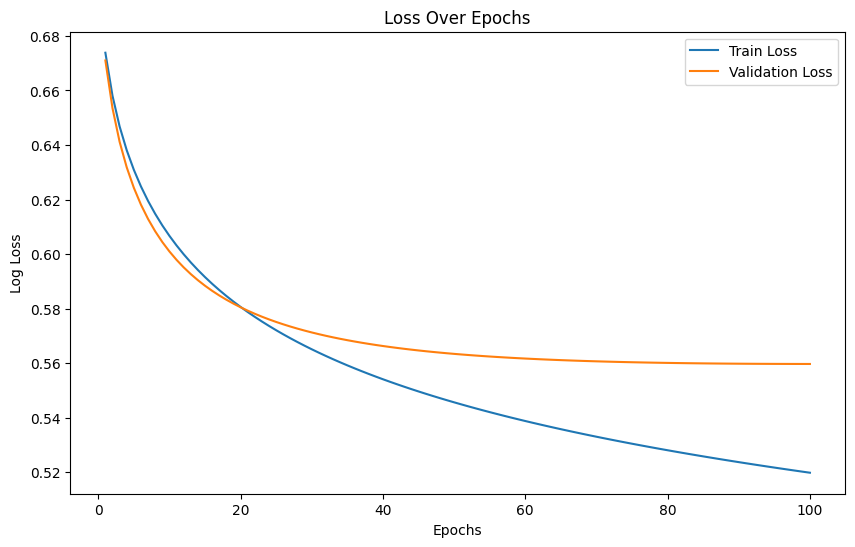

In [69]:
#PLotting Loss
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, n_epochs + 1), val_losses, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.legend()
plt.show()


Integrating additional features from the Hippocorpus dataset into a pre-trained BERT model for classification

In [42]:
import pandas as pd

# Load the dataset
df = pd.read_csv('hcV3-stories.csv')

# Convert categorical variables to numeric
categorical_cols = ['annotatorAge', 'annotatorGender', 'annotatorRace']
df = pd.get_dummies(df, columns=categorical_cols)

# Normalize numerical variables
numerical_cols = ['WorkTimeInSeconds', 'distracted', 'draining', 'frequency', 'importance', 'logTimeSinceEvent', 'openness', 'similarity', 'stressful']
df[numerical_cols] = df[numerical_cols].apply(lambda x: (x - x.mean()) / x.std())

# Handle missing values if any
df = df.fillna(0)



In [43]:
# BERT embeddings
from transformers import BertTokenizer, BertModel
import torch
import numpy as np

# Check if CUDA (GPU support) is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained model tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(device)

def get_bert_embeddings(text):
    if not text.strip():
        return np.zeros((768,))
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(1).cpu().numpy().reshape(-1)

# Apply the function to a subset of the dataset for demonstration
df['bert_embeddings'] = df['story'].apply(get_bert_embeddings)


In [44]:
# Filtering the DataFrame to include only 'recalled' and 'imagined' stories
df = df[df['memType'].isin(['recalled', 'imagined'])]

# Encoding 'memType' into binary format: 'recalled' as 0 and 'imagined' as 1
df['memType'] = df['memType'].map({'recalled': 0, 'imagined': 1})

# Normalizing numerical variables
numerical_cols = ['WorkTimeInSeconds', 'distracted', 'draining', 'frequency', 'importance', 'logTimeSinceEvent', 'openness', 'similarity', 'stressful']
df[numerical_cols] = df[numerical_cols].apply(lambda x: (x - x.mean()) / x.std())

# Handle missing values if any
df = df.fillna(0)

# Columns that are already one-hot encoded
one_hot_encoded_cols = [col for col in df.columns if 'annotatorAge_' in col or 'annotatorGender_' in col or 'annotatorRace_' in col]

# Combining BERT embeddings with other features
other_features = df[numerical_cols + one_hot_encoded_cols].values
bert_embeddings = np.array(df['bert_embeddings'].tolist())

# Stack horizontally
X = np.hstack((bert_embeddings, other_features))

# Target variable
y = df['memType'].values

# Splitting the data
from sklearn.model_selection import train_test_split

# Let's create a new column for indices
df['original_index'] = df.index
y = df['memType'].values

# Split the data
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
    X, y, df['original_index'], test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val, indices_train, indices_val = train_test_split(
    X_train, y_train, indices_train, test_size=0.25, random_state=42)


In [48]:
# X_train = np.array(X_train, dtype='float32')
# X_val = np.array(X_val, dtype='float32')
# X_test = np.array(X_test, dtype='float32')

# y_train = np.array(y_train, dtype='float32')
# y_val = np.array(y_val, dtype='float32')
# y_test = np.array(y_test, dtype='float32')

# X_train = np.nan_to_num(X_train)
# X_val = np.nan_to_num(X_val)
# X_test = np.nan_to_num(X_test)




In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Define the model
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model and save the history
epochs = 20
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=32)


Epoch 1/20
104/104 [==============================] - 1s 3ms/step - loss: 0.6521 - accuracy: 0.6131 - val_loss: 0.4934 - val_accuracy: 0.7633
Epoch 2/20
104/104 [==============================] - 0s 2ms/step - loss: 0.4913 - accuracy: 0.7585 - val_loss: 0.4231 - val_accuracy: 0.7868
Epoch 3/20
104/104 [==============================] - 0s 3ms/step - loss: 0.4114 - accuracy: 0.8181 - val_loss: 0.3360 - val_accuracy: 0.8618
Epoch 4/20
104/104 [==============================] - 0s 2ms/step - loss: 0.3315 - accuracy: 0.8561 - val_loss: 0.2659 - val_accuracy: 0.8880
Epoch 5/20
104/104 [==============================] - 0s 2ms/step - loss: 0.2604 - accuracy: 0.8982 - val_loss: 0.2118 - val_accuracy: 0.9178
Epoch 6/20
104/104 [==============================] - 0s 3ms/step - loss: 0.2105 - accuracy: 0.9247 - val_loss: 0.1573 - val_accuracy: 0.9395
Epoch 7/20
104/104 [==============================] - 0s 3ms/step - loss: 0.1728 - accuracy: 0.9338 - val_loss: 0.1424 - val_accuracy: 0.9440
Epoch 

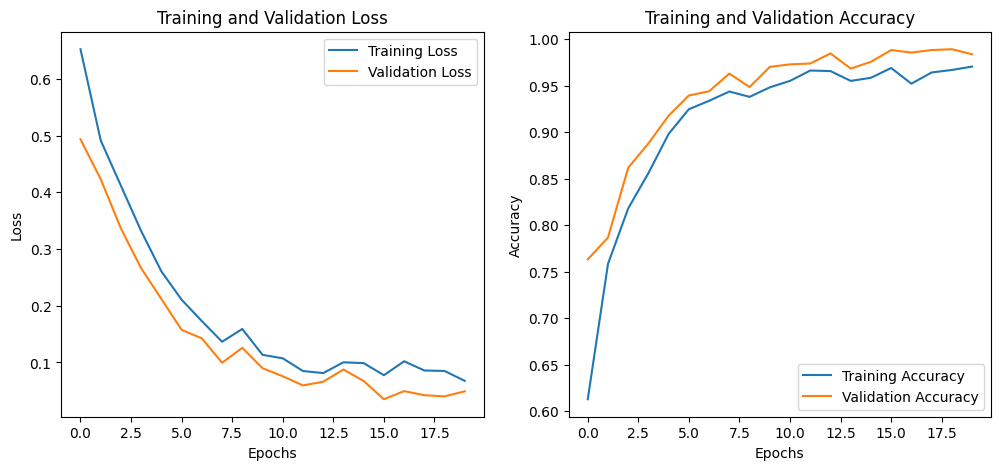

In [50]:
import matplotlib.pyplot as plt

# Plotting training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [51]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


35/35 [==============================] - 0s 1ms/step - loss: 0.0487 - accuracy: 0.9774
Test Loss: 0.0486774668097496
Test Accuracy: 0.977416455745697


In [52]:
# Select a sample from the test set
sample_index = indices_test[0]  # Index in the original DataFrame
sample_input = X_test[0]
sample_true_label = y_test[0]

# Make a prediction
sample_prediction = model.predict(sample_input.reshape(1, -1))
predicted_label = (sample_prediction > 0.5).astype("int32").flatten()[0]

# Print the corresponding story and the prediction
sample_story = df.loc[sample_index, 'story']
print("Sample Story Text:")
print(sample_story)
print("\nTrue Label:", 'Imagined' if sample_true_label == 1 else 'Recalled')
print("Predicted Label:", 'Imagined' if predicted_label == 1 else 'Recalled')


1/1 [==============================] - 0s 44ms/step
Sample Story Text:
Concerts are my most favorite thing, and my boyfriend knew it. That's why, for our anniversary, he got me tickets to see my favorite artist. Not only that, but the tickets were for an outdoor show, which I love much more than being in a crowded stadium. Since he knew I was such a big fan of music, he got tickets for himself, and even a couple of my friends. He is so incredibly nice and considerate to me and what I like to do. I will always remember this event and I will always cherish him. On the day of the concert, I got ready, and he picked me up and we went out to a restaurant beforehand. He is so incredibly romantic. He knew exactly where to take me without asking. We ate, laughed, and had a wonderful dinner date before the big event. We arrived at the concert and the music was so incredibly beautiful. I loved every minute of it. My friends, boyfriend, and I all sat down next to each other. As the music was slow

Using a dervived linguistic feature

Sentiment analysis can provide meaningful insights, especially in distinguishing between different types of narratives like recalled versus imagined events. The sentiment of a story can reveal underlying emotional tones, which might vary significantly between remembered and fictional accounts.

In [55]:
#!pip install textblob

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

from textblob import TextBlob

def get_sentiment(text):
    # Create a TextBlob object
    blob = TextBlob(text)
    # Return the polarity
    return blob.sentiment.polarity

# Apply the function to each story
df['sentiment_polarity'] = df['story'].apply(get_sentiment)


[nltk_data] Downloading package punkt to
[nltk_data]     /common/home/rsv39/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /common/home/rsv39/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [56]:
#Preprocess Data

import pandas as pd
from textblob import TextBlob

# Load the dataset
df = pd.read_csv('hcV3-stories.csv')

# Filter for only 'recalled' and 'imagined' types
df = df[df['memType'].isin(['recalled', 'imagined'])]

# Function to calculate sentiment polarity
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

# Add sentiment polarity as a feature
df['sentiment_polarity'] = df['story'].apply(get_sentiment)

# Encode 'memType' into binary format: 'recalled' as 0 and 'imagined' as 1
df['memType'] = df['memType'].map({'recalled': 0, 'imagined': 1})


In [57]:
#Extract BERT Embeddings
from transformers import BertTokenizer, BertModel
import torch
import numpy as np

# Initialize tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Function to get BERT embeddings
def get_bert_embeddings(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(1).detach().numpy().reshape(-1)

# Apply the function to extract embeddings
df['bert_embeddings'] = df['story'].apply(get_bert_embeddings)


In [58]:
#Prepare Data for Model Training

# Combining BERT embeddings with the sentiment feature
X_bert = np.stack(df['bert_embeddings'].values)
X_sentiment = df['sentiment_polarity'].values.reshape(-1, 1)
X = np.hstack((X_bert, X_sentiment))

# Target variable
y = df['memType'].values

# Splitting the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)


In [59]:
#Model Training

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Define the model
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)


Epoch 1/10
104/104 [==============================] - 1s 4ms/step - loss: 0.7038 - accuracy: 0.5333 - val_loss: 0.6681 - val_accuracy: 0.5962
Epoch 2/10
104/104 [==============================] - 0s 2ms/step - loss: 0.6641 - accuracy: 0.5950 - val_loss: 0.6290 - val_accuracy: 0.6667
Epoch 3/10
104/104 [==============================] - 0s 2ms/step - loss: 0.6374 - accuracy: 0.6465 - val_loss: 0.6185 - val_accuracy: 0.6621
Epoch 4/10
104/104 [==============================] - 0s 2ms/step - loss: 0.6267 - accuracy: 0.6450 - val_loss: 0.6101 - val_accuracy: 0.6847
Epoch 5/10
104/104 [==============================] - 0s 2ms/step - loss: 0.6096 - accuracy: 0.6724 - val_loss: 0.6101 - val_accuracy: 0.6685
Epoch 6/10
104/104 [==============================] - 0s 3ms/step - loss: 0.6064 - accuracy: 0.6709 - val_loss: 0.6039 - val_accuracy: 0.6766
Epoch 7/10
104/104 [==============================] - 0s 2ms/step - loss: 0.5975 - accuracy: 0.6763 - val_loss: 0.5916 - val_accuracy: 0.6938
Epoch 

Epoch 1/10
104/104 [==============================] - 0s 2ms/step - loss: 0.5805 - accuracy: 0.6923 - val_loss: 0.5890 - val_accuracy: 0.6838
Epoch 2/10
104/104 [==============================] - 0s 2ms/step - loss: 0.5802 - accuracy: 0.7001 - val_loss: 0.5810 - val_accuracy: 0.6911
Epoch 3/10
104/104 [==============================] - 0s 2ms/step - loss: 0.5822 - accuracy: 0.6847 - val_loss: 0.6006 - val_accuracy: 0.6658
Epoch 4/10
104/104 [==============================] - 0s 2ms/step - loss: 0.5865 - accuracy: 0.6899 - val_loss: 0.5787 - val_accuracy: 0.6956
Epoch 5/10
104/104 [==============================] - 0s 2ms/step - loss: 0.5701 - accuracy: 0.6953 - val_loss: 0.5843 - val_accuracy: 0.6920
Epoch 6/10
104/104 [==============================] - 0s 2ms/step - loss: 0.5650 - accuracy: 0.7028 - val_loss: 0.5829 - val_accuracy: 0.6965
Epoch 7/10
104/104 [==============================] - 0s 2ms/step - loss: 0.5607 - accuracy: 0.7064 - val_loss: 0.5742 - val_accuracy: 0.6992
Epoch 

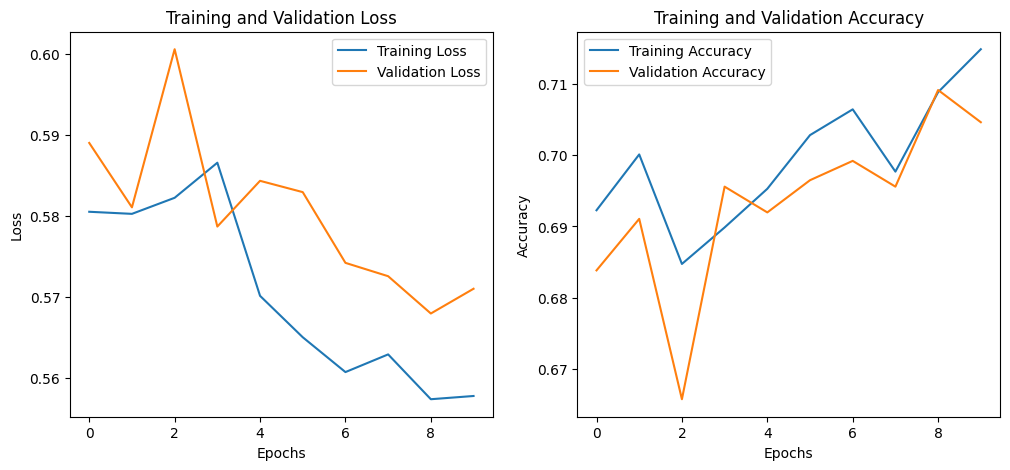

In [60]:
#Plots

import matplotlib.pyplot as plt

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

# Plotting training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [61]:
#Evaluate test accuracy

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")


35/35 [==============================] - 0s 1ms/step - loss: 0.5789 - accuracy: 0.6829
Test Accuracy: 0.6829268336296082


In [64]:
#Print sample prediction

# Select a sample from the test set
sample_index = 2  # Example: the first sample in the test set
sample_input = X_test[sample_index]
sample_true_label = y_test[sample_index]

# Make a prediction
sample_prediction = model.predict(sample_input.reshape(1, -1))
predicted_label = (sample_prediction > 0.5).astype("int32")[0, 0]

# Retrieve the corresponding story (assuming 'story' column exists in df)
sample_story = df.iloc[sample_index]['story']

# Print the details
print("Sample Story Text:")
print(sample_story)
print("\nTrue Label:", 'Imagined' if sample_true_label == 1 else 'Recalled')
print("Predicted Label:", 'Imagined' if predicted_label == 1 else 'Recalled')


1/1 [==============================] - 0s 14ms/step
Sample Story Text:
It seems just like yesterday but today makes five months ago it happened. I had been watching my phone like an owl for the past week. I was waiting for a work related call that my team was waiting for to close a important deal. It wasnt the call I expected though. It was for  my sister was in labor with the twins. My sister is only 7 months pregnant. I got the call shortly after arriving at work. Just as fast I was back out the door and on my way to the hospital. When I arrived my sister had just delivered and I just was in awe. Even though they were a bit small they were mighty. They were the most precious things I had ever seen. I held my niece and nephew and couldnt stop crying. Seeing the tears of joy my sister had was the most warming thing. I am a mother myself but this was the first time for my sister. It was a moment that we could bond and share the warmth of motherhood. I will never forget the look on my br

35/35 [==============================] - 0s 1ms/step


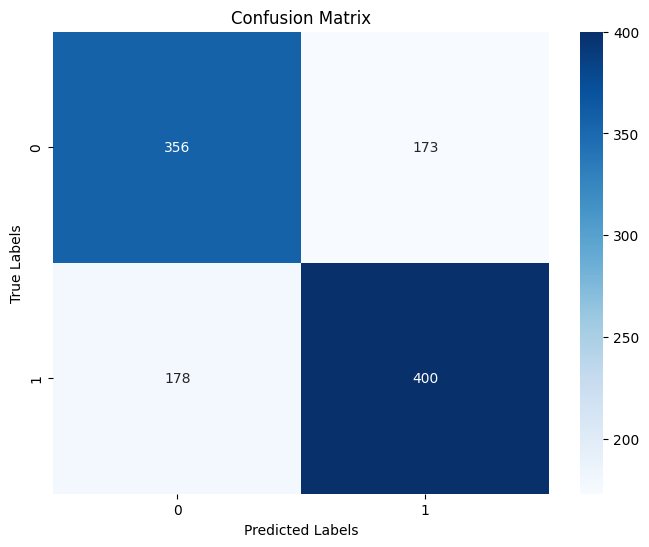

              precision    recall  f1-score   support

    Recalled       0.67      0.67      0.67       529
    Imagined       0.70      0.69      0.70       578

    accuracy                           0.68      1107
   macro avg       0.68      0.68      0.68      1107
weighted avg       0.68      0.68      0.68      1107



In [65]:
# Get predictions for the test set

test_predictions = model.predict(X_test)
test_predicted_labels = (test_predictions > 0.5).astype("int32").flatten()

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, test_predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Print classification report
print(classification_report(y_test, test_predicted_labels, target_names=['Recalled', 'Imagined']))


The classification report offers several key insights into the performance of the model on the test set. Here are some observations and interpretations:


__Overall Accuracy:__

The model has an overall accuracy of 68%. This means it correctly predicts whether a story is recalled or imagined 68% of the time. While this is better than random guessing (which would be 50% accuracy for a balanced binary classification task), there might still be room for improvement.

__Precision:__

The precision for 'Recalled' is 67%, and for 'Imagined' it is 70%. Precision reflects the proportion of true positive predictions among all positive predictions. In other words, when the model predicts 'Recalled', it is correct 67% of the time, and when it predicts 'Imagined', it is correct 70% of the time.

__Recall:__

The recall for 'Recalled' is 67%, and for 'Imagined' it is 69%. Recall indicates how many of the actual positive cases the model successfully captures through labeling it as positive. So, the model correctly identifies 67% of all actual 'Recalled' stories and 69% of all actual 'Imagined' stories.

__F1-Score:__

The F1-score, which is the harmonic mean of precision and recall, is 67% for 'Recalled' and 70% for 'Imagined'. This metric is particularly useful because it captures the balance between precision and recall. A high F1-score is an indicator of a well-performing model.

__Class Balance:__

The support for 'Recalled' is 529 and for 'Imagined' is 578, indicating a fairly balanced dataset. This balance is important because it means the model's accuracy is not skewed by a class imbalance.

__Interpretations:__

__Balanced Performance:__ The model shows a relatively balanced performance across both classes, with similar precision, recall, and F1-scores for 'Recalled' and 'Imagined' categories.

__Room for Improvement:__ While the performance is decent, there's still potential to improve. Enhancing the model could involve tuning hyperparameters, experimenting with different architectures, or incorporating more diverse or complex features.

__Error Analysis:__ Investigating the instances where the model makes incorrect predictions could provide insights into whether the model struggles more with certain types of narratives or specific linguistic features.

Overall, the model appears to be a good starting point but may benefit from further optimization and refinement to improve its predictive capabilities, especially in a nuanced task like distinguishing between recalled and imagined stories.